# Supervised Learning Model Evaluation - In-Class Exercises

In this notebook, you will practice evaluating supervised learning models using proper train-test splitting strategies, computing various evaluation metrics, and performing cross-validation with confidence intervals.

**Datasets:**
- **Titanic**: Binary classification (Survived: 0 or 1) - imbalanced dataset
- **Iris**: Multiclass classification (3 species) - balanced dataset

**Learning Objectives:**
- Implement proper train-test splitting strategies
- Compute and interpret evaluation metrics for binary and multiclass problems
- Calculate ROC curves
- Perform cross-validation with confidence intervals

## Setup: Import Libraries

All necessary imports are provided below.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report
)

# Set random seed for reproducibility
np.random.seed(42)

---
## Part 1: Binary Classification - Titanic Dataset

### Dataset Loading and Preprocessing

The code below loads and preprocesses the Titanic dataset. This is provided for you.

In [10]:
# Load Titanic dataset
titanic = sns.load_dataset('titanic')

# Display first few rows and info
print("Dataset shape:", titanic.shape)
print("\nFirst few rows:")
display(titanic.head())
print("\nMissing values:")
print(titanic.isnull().sum())
print("\nClass distribution:")
print(titanic['survived'].value_counts())

Dataset shape: (891, 15)

First few rows:


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True



Missing values:
survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Class distribution:
survived
0    549
1    342
Name: count, dtype: int64


In [16]:
# Preprocessing: Select features and handle missing values
# Select relevant features
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
target = 'survived'

# Create a copy with selected features
df_titanic = titanic[features + [target]].copy()

# Handle missing values
# Fill missing age with median
df_titanic['age'] = df_titanic['age'].fillna(df_titanic['age'].median())

# Fill missing embarked with mode
df_titanic['embarked'] = df_titanic['embarked'].fillna(df_titanic['embarked'].mode()[0])

# Fill missing fare with median
df_titanic['fare'] = df_titanic['fare'].fillna(df_titanic['fare'].median())

# Encode categorical variables
df_titanic['sex'] = df_titanic['sex'].map({'male': 0, 'female': 1})
df_titanic = pd.get_dummies(df_titanic, columns=['embarked'], prefix='embarked', drop_first=True)

# Separate features and target
X_titanic = df_titanic.drop(target, axis=1)
y_titanic = df_titanic[target]

print("Preprocessed dataset shape:", X_titanic.shape)
print("Features:", list(X_titanic.columns))
print("\nNo missing values remaining:", X_titanic.isnull().sum().sum())

Preprocessed dataset shape: (891, 8)
Features: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked_Q', 'embarked_S']

No missing values remaining: 0


---
## ✏️ Exercise 1: Train-Test Split with Stratification

**Task:** Create a train-test split for the Titanic dataset.

**Requirements:**
- Use 70% of the data for training and 30% for testing
- Set `random_state=42` for reproducibility
- Store the results in variables: `X_train_titanic`, `X_test_titanic`, `y_train_titanic`, `y_test_titanic`

*Tip: For imbalanced datasets like Titanic, consider whether you want the same class distribution in both train and test sets. Check the `stratify` parameter in the documentation.*

In [28]:
# ===== STUDENT CODE START =====
from sklearn.model_selection import train_test_split

X_train_titanic, X_test_titanic, y_train_titanic, y_test_titanic = train_test_split(
    X_titanic,
    y_titanic,
    test_size=0.3,
    random_state=42,
    stratify=y_titanic
)

# ===== STUDENT CODE END =====

In [29]:
# Verify the split by checking shapes and class distributions
print("Train set shape:", X_train_titanic.shape)
print("Test set shape:", X_test_titanic.shape)
print("\nTrain set class distribution:")
print(y_train_titanic.value_counts(normalize=True))
print("\nTest set class distribution:")
print(y_test_titanic.value_counts(normalize=True))

Train set shape: (623, 8)
Test set shape: (268, 8)

Train set class distribution:
survived
0    0.616372
1    0.383628
Name: proportion, dtype: float64

Test set class distribution:
survived
0    0.615672
1    0.384328
Name: proportion, dtype: float64


### Model Training Code 

Below is the model training code. **Warning** - you will need to create the train-test split first in Exercise 1.

In [32]:
# Train a Logistic Regression model
# This cell should be run AFTER you complete Exercise 1

model_titanic = LogisticRegression(max_iter=1000, random_state=42)
model_titanic.fit(X_train_titanic, y_train_titanic)

# Make predictions
y_pred_titanic = model_titanic.predict(X_test_titanic)
y_pred_proba_titanic = model_titanic.predict_proba(X_test_titanic)[:, 1]

print("Model trained successfully!")

Model trained successfully!


---
## ✏️ Exercise 2: Binary Classification Evaluation Metrics

**Task:** Calculate the following evaluation metrics for the Titanic model:
1. Confusion Matrix
2. Accuracy
3. Precision
4. Recall
5. F1-Score
6. ROC-AUC Score

**Visualization Requirements:**
- Create a heatmap visualization of the confusion matrix using seaborn
- Plot the ROC curve with AUC score using matplotlib

*Tip: All these functions are available in `sklearn.metrics`. For ROC-AUC, you'll need predicted probabilities, not just class predictions.*

TITANIC DATASET - Binary Classification Metrics

Confusion Matrix:
[[139  26]
 [ 28  75]]

Accuracy: 0.7985
Precision: 0.7426
Recall: 0.7282
F1-Score: 0.7353
ROC-AUC Score: 0.8494


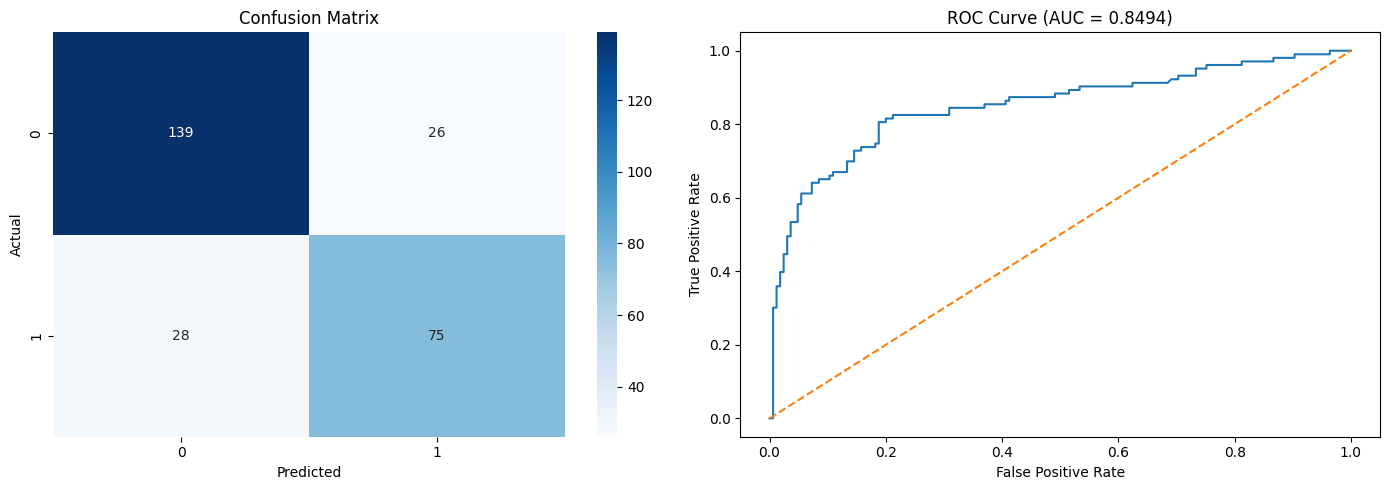

In [34]:
# ===== STUDENT CODE START =====
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Make predictions
y_pred_titanic = model_titanic.predict(X_test_titanic)

# Get predicted probabilities (needed for ROC-AUC)
y_prob_titanic = model_titanic.predict_proba(X_test_titanic)[:, 1]

# Confusion Matrix
cm_titanic = confusion_matrix(y_test_titanic, y_pred_titanic)

# Metrics
accuracy_titanic = accuracy_score(y_test_titanic, y_pred_titanic)
precision_titanic = precision_score(y_test_titanic, y_pred_titanic)
recall_titanic = recall_score(y_test_titanic, y_pred_titanic)
f1_titanic = f1_score(y_test_titanic, y_pred_titanic)

# ROC-AUC
roc_auc_titanic = roc_auc_score(y_test_titanic, y_prob_titanic)

# ===== STUDENT CODE END =====

# Print results
print("="*60)
print("TITANIC DATASET - Binary Classification Metrics")
print("="*60)
print("\nConfusion Matrix:")
print(cm_titanic)
print(f"\nAccuracy: {accuracy_titanic:.4f}")
print(f"Precision: {precision_titanic:.4f}")
print(f"Recall: {recall_titanic:.4f}")
print(f"F1-Score: {f1_titanic:.4f}")
print(f"ROC-AUC Score: {roc_auc_titanic:.4f}")

# Visualizations
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap and ROC Curve
# ===== STUDENT CODE START =====
import seaborn as sns

# --- Confusion Matrix Heatmap ---
sns.heatmap(
    cm_titanic,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=axes[0]
)

axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# --- ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test_titanic, y_prob_titanic)

axes[1].plot(fpr, tpr)
axes[1].plot([0, 1], [0, 1], linestyle="--")  # diagonal line
axes[1].set_title(f"ROC Curve (AUC = {roc_auc_titanic:.4f})")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")

plt.tight_layout()
plt.show()

# ===== STUDENT CODE END =====


---
## Part 2: Multiclass Classification - Iris Dataset

### Dataset Loading

The Iris dataset is balanced and clean, requiring minimal preprocessing.

In [39]:
# Load Iris dataset
iris = load_iris()
X_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
y_iris = iris.target

print("Dataset shape:", X_iris.shape)
print("Target classes:", iris.target_names)
print("\nClass distribution:")
print(pd.Series(y_iris).value_counts().sort_index())
print("\nFirst few rows:")
display(X_iris.head())

print("\n" + "="*60)
print("Feature Statistics (Before Scaling)")
print("="*60)
display(X_iris.describe())

Dataset shape: (150, 4)
Target classes: ['setosa' 'versicolor' 'virginica']

Class distribution:
0    50
1    50
2    50
Name: count, dtype: int64

First few rows:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2



Feature Statistics (Before Scaling)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [40]:
# Preprocessing: Feature Scaling
# Many sklearn models (e.g., Logistic Regression, SVM, KNN) benefit from scaled features
# StandardScaler standardizes features by removing the mean and scaling to unit variance

scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)
X_iris = pd.DataFrame(X_iris_scaled, columns=iris.feature_names)

print("="*60)
print("Feature Statistics (After Scaling)")
print("="*60)
display(X_iris.describe())
print("\nFeatures are now scaled with mean ≈ 0 and std ≈ 1")
print("This improves performance for distance-based and gradient-based models")

Feature Statistics (After Scaling)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,1.500000e+02,1.500000e+02,1.500000e+02,1.500000e+02
mean,-1.468455e-15,-1.823726e-15,-1.610564e-15,-9.473903e-16
std,1.003350e+00,1.003350e+00,1.003350e+00,1.003350e+00
min,-1.870024e+00,-2.433947e+00,-1.567576e+00,-1.447076e+00
25%,-9.006812e-01,-5.923730e-01,-1.226552e+00,-1.183812e+00
50%,-5.250608e-02,-1.319795e-01,3.364776e-01,1.325097e-01
75%,6.745011e-01,5.586108e-01,7.627583e-01,7.906707e-01
max,2.492019e+00,3.090775e+00,1.785832e+00,1.712096e+00



Features are now scaled with mean ≈ 0 and std ≈ 1
This improves performance for distance-based and gradient-based models


---
## ✏️ Exercise 3: Train-Test Split for Balanced Dataset

**Task:** Create a train-test split for the Iris dataset.

**Requirements:**
- Use 70% of the data for training and 30% for testing
- Set `random_state=42` for reproducibility
- Store the results in variables: `X_train_iris`, `X_test_iris`, `y_train_iris`, `y_test_iris`

*Note: Since Iris is a balanced dataset, stratification is optional but still good practice.*

In [47]:
# ===== STUDENT CODE START =====
from sklearn.model_selection import train_test_split

X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris,
    y_iris,
    test_size=0.3,      # 30% test, 70% train
    random_state=42,    # reproducibility
    stratify=y_iris     # keeps class distribution consistent
)
print(X_train_iris.shape)
print(X_test_iris.shape)

# ===== STUDENT CODE END =====

(105, 4)
(45, 4)


In [51]:
# Verify the split
print("Train set shape:", X_train_iris.shape)
print("Test set shape:", X_test_iris.shape)
print("\nTrain set class distribution:")
print(pd.Series(y_train_iris).value_counts().sort_index())
print("\nTest set class distribution:")
print(pd.Series(y_test_iris).value_counts().sort_index())

Train set shape: (105, 4)
Test set shape: (45, 4)

Train set class distribution:
0    35
1    35
2    35
Name: count, dtype: int64

Test set class distribution:
0    15
1    15
2    15
Name: count, dtype: int64


### Model Training Code

Below is the model training code. **Warning** - complete Exercise 3 first.

In [54]:
# Train a Logistic Regression model for multiclass classification
# This cell should be run AFTER you complete Exercise 3

model_iris = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
model_iris.fit(X_train_iris, y_train_iris)

# Make predictions
y_pred_iris = model_iris.predict(X_test_iris)
y_pred_proba_iris = model_iris.predict_proba(X_test_iris)

print("Model trained successfully!")
print(f"Training set size: {len(X_train_iris)}")
print(f"Test set size: {len(X_test_iris)}")

Model trained successfully!
Training set size: 105
Test set size: 45


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


---
## ✏️ Exercise 4: Multiclass Classification Evaluation Metrics

**Task:** Calculate the following evaluation metrics for the Iris model:
1. Confusion Matrix
2. Overall Accuracy
3. Precision (macro, micro, and weighted averages)
4. Recall (macro, micro, and weighted averages)
5. F1-Score (macro, micro, and weighted averages)

**Visualization Requirement:**
- Create a heatmap visualization of the confusion matrix using seaborn with proper class labels

*Tip: For multiclass metrics, check the `average` parameter. Different averaging methods give you different perspectives on model performance.*

**'macro':** (Default in many functions): Calculates the metric for each label and finds their unweighted mean. This does not take label imbalance into account.

**'weighted':** Calculates the metric for each label and finds their average, weighted by support (the number of true instances for each label). This accounts for label imbalance.

**'micro':** Calculates metrics globally by counting the total true positives, false negatives, and false positives.*

IRIS DATASET - Multiclass Classification Metrics

Confusion Matrix:
[[15  0  0]
 [ 0 11  4]
 [ 0  3 12]]

Overall Accuracy: 0.8444

Precision:
  Macro:    0.8452
  Micro:    0.8444
  Weighted: 0.8452

Recall:
  Macro:    0.8444
  Micro:    0.8444
  Weighted: 0.8444

F1-Score:
  Macro:    0.8443
  Micro:    0.8444
  Weighted: 0.8443


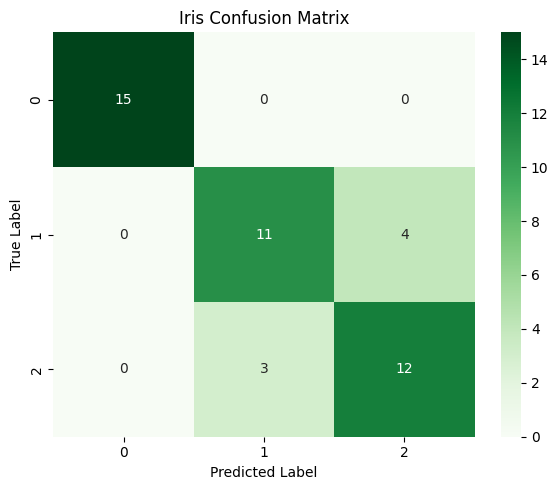

In [56]:

# ===== STUDENT CODE START =====
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Predictions
y_pred_iris = model_iris.predict(X_test_iris)

# Confusion Matrix
cm_iris = confusion_matrix(y_test_iris, y_pred_iris)

# Overall Accuracy
accuracy_iris = accuracy_score(y_test_iris, y_pred_iris)

# Precision
precision_macro_iris = precision_score(y_test_iris, y_pred_iris, average='macro')
precision_micro_iris = precision_score(y_test_iris, y_pred_iris, average='micro')
precision_weighted_iris = precision_score(y_test_iris, y_pred_iris, average='weighted')

# Recall
recall_macro_iris = recall_score(y_test_iris, y_pred_iris, average='macro')
recall_micro_iris = recall_score(y_test_iris, y_pred_iris, average='micro')
recall_weighted_iris = recall_score(y_test_iris, y_pred_iris, average='weighted')

# F1-Score
f1_macro_iris = f1_score(y_test_iris, y_pred_iris, average='macro')
f1_micro_iris = f1_score(y_test_iris, y_pred_iris, average='micro')
f1_weighted_iris = f1_score(y_test_iris, y_pred_iris, average='weighted')

# ===== END CODE START =====

# Print results
print("="*60)
print("IRIS DATASET - Multiclass Classification Metrics")
print("="*60)
print("\nConfusion Matrix:")
print(cm_iris)
print(f"\nOverall Accuracy: {accuracy_iris:.4f}")
print("\nPrecision:")
print(f"  Macro:    {precision_macro_iris:.4f}")
print(f"  Micro:    {precision_micro_iris:.4f}")
print(f"  Weighted: {precision_weighted_iris:.4f}")
print("\nRecall:")
print(f"  Macro:    {recall_macro_iris:.4f}")
print(f"  Micro:    {recall_micro_iris:.4f}")
print(f"  Weighted: {recall_weighted_iris:.4f}")
print("\nF1-Score:")
print(f"  Macro:    {f1_macro_iris:.4f}")
print(f"  Micro:    {f1_micro_iris:.4f}")
print(f"  Weighted: {f1_weighted_iris:.4f}")

# Visualize Confusion Matrix 


# ===== STUDENT CODE START =====
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))

sns.heatmap(
    cm_iris,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=model_iris.classes_,
    yticklabels=model_iris.classes_
)

plt.title("Iris Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ===== END CODE START =====


---
## ✏️ Part 3: Cross-Validation with Confidence Intervals

### Exercise 5: K-Fold Cross-Validation with Confidence Intervals

**Task:** Perform stratified k-fold cross-validation on both datasets and calculate 95% confidence intervals for the F1-scores.

**Requirements:**
1. Use 5-fold stratified cross-validation
2. Calculate cross-validation F1-scores for both Titanic and Iris datasets
3. For each dataset, compute:
   - Mean F1-score
   - Standard deviation
   - 95% confidence interval using the t-distribution

*Tip: Cross-validation returns an array of scores (one per fold). The standard error (SE) is calculated as std/sqrt(n) where n is the number of folds. For a 95% confidence interval with a t-distribution, you'll need the degrees of freedom (n-1). Consider using `scipy.stats.t.interval()`. For F1-score with binary classification, use `scoring='f1'`. For multiclass, use `scoring='f1_macro'`.*

In [58]:
# ===== STUDENT CODE START =====
from sklearn.model_selection import StratifiedKFold, cross_val_score
from scipy import stats
import numpy as np

# 5-fold stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -------------------------
# TITANIC (Binary → F1)
# -------------------------
f1_scores_titanic = cross_val_score(
    model_titanic,
    X_titanic,
    y_titanic,
    cv=skf,
    scoring='f1'
)

mean_f1_titanic = np.mean(f1_scores_titanic)
std_f1_titanic = np.std(f1_scores_titanic, ddof=1)

# Standard Error
se_titanic = std_f1_titanic / np.sqrt(len(f1_scores_titanic))

# 95% CI using t-distribution
ci_titanic = stats.t.interval(
    confidence=0.95,
    df=len(f1_scores_titanic)-1,
    loc=mean_f1_titanic,
    scale=se_titanic
)

# -------------------------
# IRIS (Multiclass → F1 Macro)
# -------------------------
f1_scores_iris = cross_val_score(
    model_iris,
    X_iris,
    y_iris,
    cv=skf,
    scoring='f1_macro'
)

mean_f1_iris = np.mean(f1_scores_iris)
std_f1_iris = np.std(f1_scores_iris, ddof=1)

se_iris = std_f1_iris / np.sqrt(len(f1_scores_iris))

ci_iris = stats.t.interval(
    confidence=0.95,
    df=len(f1_scores_iris)-1,
    loc=mean_f1_iris,
    scale=se_iris
)
print("="*60)
print("CROSS-VALIDATION RESULTS WITH 95% CONFIDENCE INTERVALS")
print("="*60)

print("\nTitanic Dataset:")
print(f"Mean F1-Score: {mean_f1_titanic:.4f}")
print(f"Standard Deviation: {std_f1_titanic:.4f}")
print(f"95% Confidence Interval: ({ci_titanic[0]:.4f}, {ci_titanic[1]:.4f})")

print("\nIris Dataset:")
print(f"Mean F1-Score (Macro): {mean_f1_iris:.4f}")
print(f"Standard Deviation: {std_f1_iris:.4f}")
print(f"95% Confidence Interval: ({ci_iris[0]:.4f}, {ci_iris[1]:.4f})")


# ===== STUDENT CODE END =====

CROSS-VALIDATION RESULTS WITH 95% CONFIDENCE INTERVALS

Titanic Dataset:
Mean F1-Score: 0.7231
Standard Deviation: 0.0276
95% Confidence Interval: (0.6888, 0.7574)

Iris Dataset:
Mean F1-Score (Macro): 0.9201
Standard Deviation: 0.0501
95% Confidence Interval: (0.8580, 0.9823)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was depre